In [1]:
import pandas as pd

In [8]:
df = pd.read_csv('CC GENERAL.csv')
df.drop('CUST_ID', axis=1, inplace=True)
# see the missing values
print(df.isnull().sum())


BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64


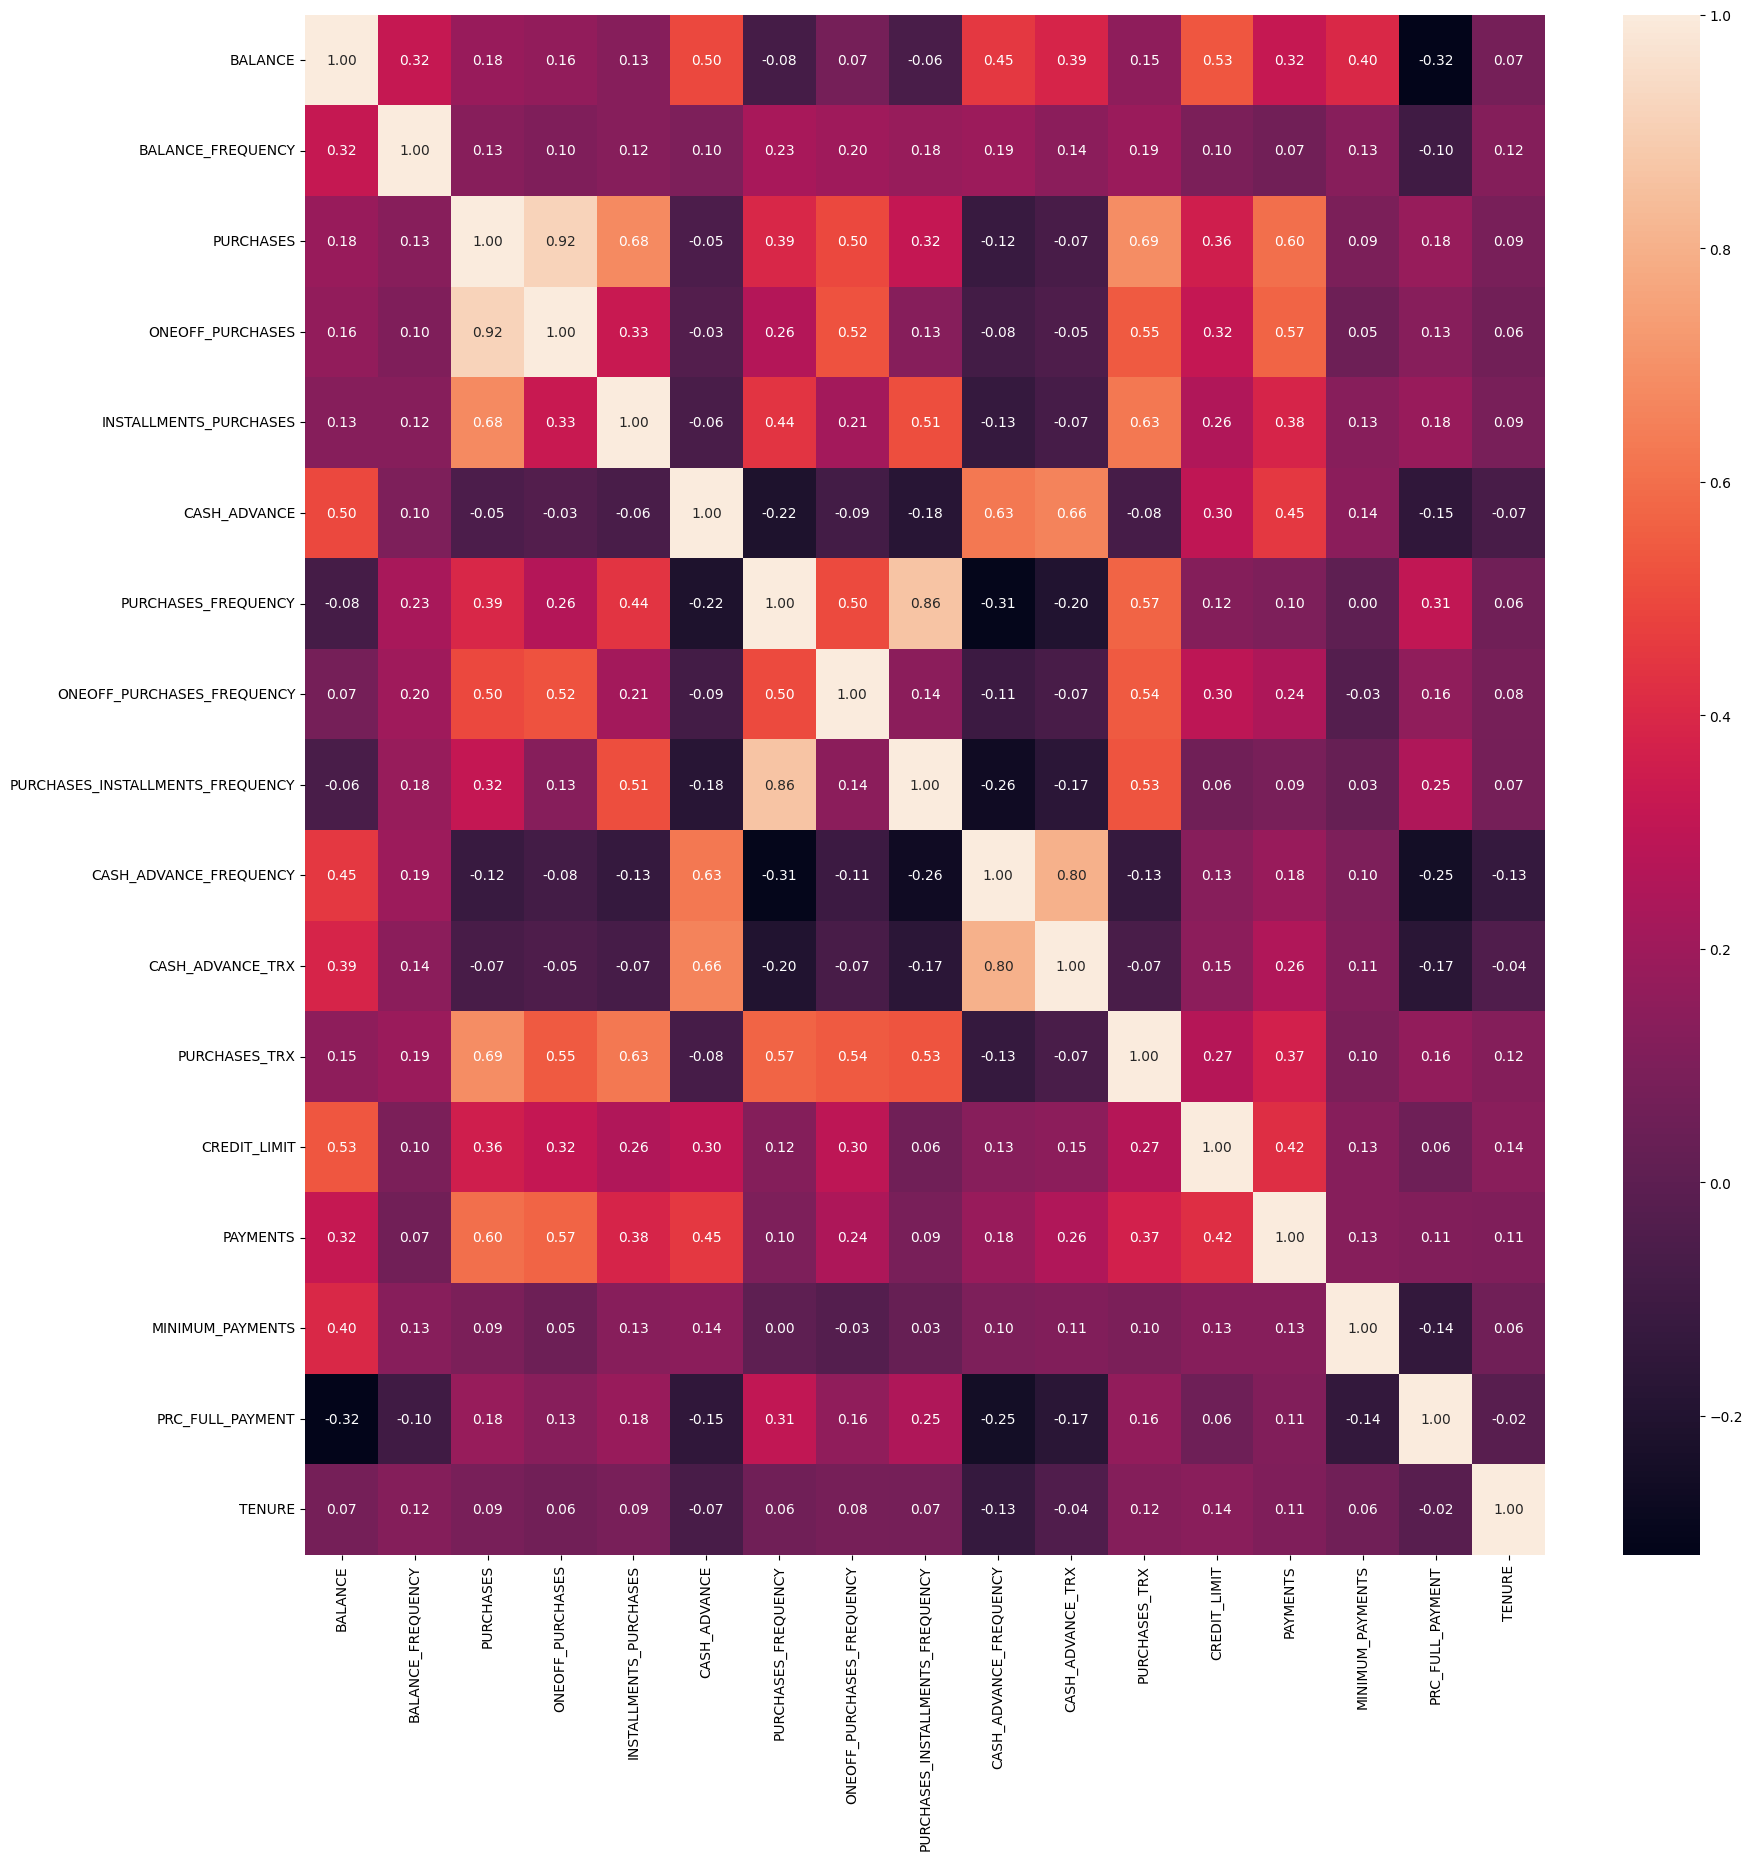

In [11]:
# plot all correlations
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
sns.heatmap(df.corr(), annot=True, fmt='.2f')
plt.show()


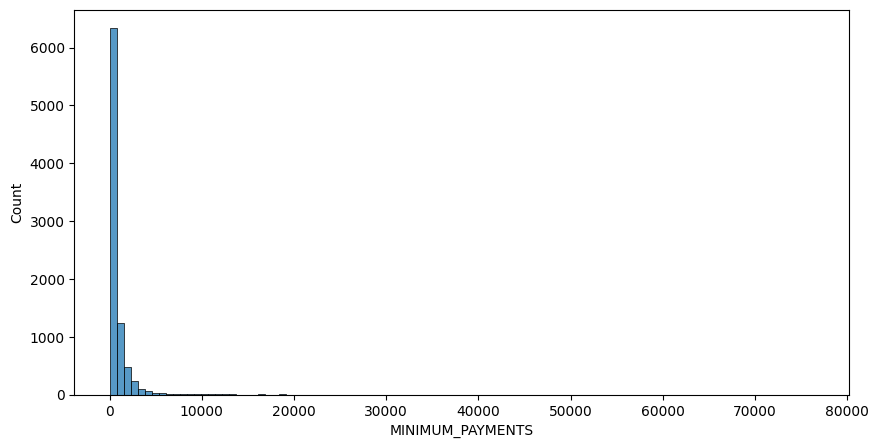

In [13]:
# plot histogram from minimum payments
plt.figure(figsize=(10, 5))
sns.histplot(df['MINIMUM_PAYMENTS'], bins=100)
plt.show()
